In [1]:
import numpy as np
import pandas as pd
import open3d
import os
import math
import tqdm
import matplotlib.pyplot as plt
import utils.helpers as helpers
import utils.fread as fread
import utils.registration as registration
import copy

from PIL import Image, ImageDraw
from utils.depth_camera import DepthCamera

from scipy import signal
from scipy import interpolate

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def remove_plane(pcd, threshold=0.01):
    plane_model, inliers = pcd.segment_plane(distance_threshold=threshold, ransac_n=3, num_iterations=1000)
    [a, b, c, d] = plane_model
    outlier_cloud = pcd.select_by_index(inliers, invert=True)
    return outlier_cloud

def rotation_matrix_to_euler_angles(R):
    sy = np.sqrt(R[0,0]**2 + R[1,0]**2)
    singular = sy < 1e-6

    if not singular:
        x = np.arctan2(R[2,1], R[2,2])
        y = np.arctan2(-R[2,0], sy)
        z = np.arctan2(R[1,0], R[0,0])
    else:
        x = np.arctan2(-R[1,2], R[1,1])
        y = np.arctan2(-R[2,0], sy)
        z = 0

    return np.degrees(np.array([x, y, z]))

In [25]:
def project_point_onto_plane(xyz, plane_eq):
    a, b, c, d = plane_eq
    x, y, z = xyz
    
    n = np.array([a, b, c]) / np.linalg.norm([a, b, c])

    # Calculate the distance between the point and the plane
    distance = np.abs(a*x + b*y + c*z + d) / np.linalg.norm([a, b, c])

    # Calculate the projected point
    return np.array([x, y, z]) - distance * n

In [26]:
def remove_hidden_points(pcd, camera_coord, radius):
    _, pt_map = pcd.hidden_point_removal(camera_coord, radius)
    return pcd.select_by_index(pt_map)

In [3]:
sequence_dir = "data/raw_data/exp_1/01"

depth_camera = DepthCamera("device-0", "data/raw_data/exp_1/metadata/device-0-aligned.json")
sequence_ts = fread.get_timstamps_from_images(sequence_dir, ext="depth.png")

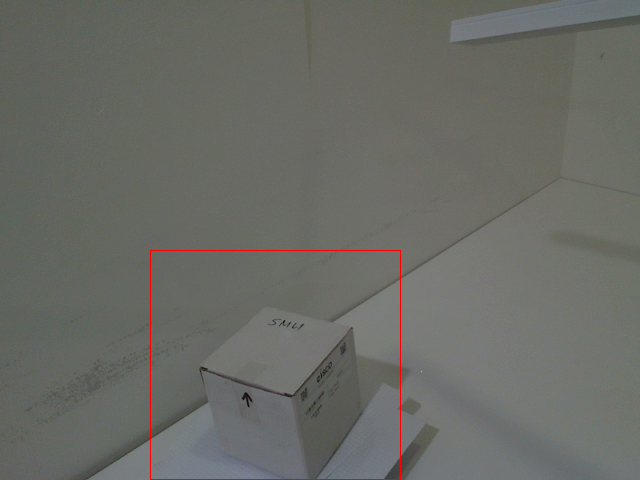

In [4]:
# Open the image
image = Image.open(os.path.join(sequence_dir, f"frame-{sequence_ts[0]}.color.png"))

# Create an ImageDraw object
draw = ImageDraw.Draw(image)

# Define the rectangle coordinates
mask = (150, 250, 400, 479)

# Draw the rectangle
draw.rectangle(mask, outline ="red")
image

In [5]:
# 360 degrees per 24 seconds
angular_velocity = 2 * np.pi / 24 # rad/s

In [139]:
source_file = os.path.join(sequence_dir, f"frame-{sequence_ts[0]}.depth.png")
target_file = os.path.join(sequence_dir, f"frame-{sequence_ts[60]}.depth.png")

source = depth_camera.depth_to_point_cloud(source_file, mask_coord=(150, 250, 400, 479))
target = depth_camera.depth_to_point_cloud(target_file, mask_coord=(150, 250, 400, 479))

source.paint_uniform_color([1, 0.706, 0])
target.paint_uniform_color([0, 0.651, 0.929])

PointCloud with 57114 points.

In [140]:
source = remove_plane(source)
source = remove_plane(source)

target = remove_plane(target)
target = remove_plane(target)

In [141]:
source = source.voxel_down_sample(voxel_size=0.01)
target = target.voxel_down_sample(voxel_size=0.01)

In [149]:
source.transform(T)
target.transform(T)

PointCloud with 1470 points.

In [151]:
c = helpers.make_pcd(np.array([[0, 0, 0]]))
c.paint_uniform_color([1, 0, 0])

PointCloud with 1 points.

In [152]:
open3d.visualization.draw_geometries([source, target, c])

In [46]:
source_fpfh = registration.compute_fpfh(source, voxel_size=0.01)
target_fpfh = registration.compute_fpfh(target, voxel_size=0.01)

# reg_result = registration.ransac_feature_matching(source, target, source_fpfh, target_fpfh, n_ransac=3, threshold=0.015)
reg_result = registration.icp_refinement(source, target, trans_init=np.identity(4), threshold=0.01, max_iteration=100)

registration.describe(source, target, reg_result)

Keypts: [1396, 1438]	No of matches: 1148	Fitness: 0.8223495702005731	Inlier RMSE: 0.0057


In [48]:
registration.view(source, target, reg_result.transformation)

In [155]:
plane_model, inliers = source.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
[a, b, c, d] = plane_model
rotation_pcd = source.select_by_index(inliers)
rotation_pcd.paint_uniform_color([0, 1, 0])

outlier_cloud = source.select_by_index(inliers, invert=True)

open3d.visualization.draw_geometries([rotation_pcd, outlier_cloud])

In [156]:
normal_vector = np.array([a, b, c])
# normalized normal vector
normal_vector = normal_vector / np.linalg.norm(normal_vector)
# find rotation
angle = angular_velocity * (sequence_ts[60] - sequence_ts[0]) / 1000
# axis–angle representation
target_copy = copy.deepcopy(target)
R = target_copy.get_rotation_matrix_from_axis_angle(normal_vector * angle)

In [159]:
t1 = copy.deepcopy(target)
t2 = copy.deepcopy(target)

transformation = np.identity(4)
transformation[:3, :3] = R

t1.transform(transformation)

transformation = np.identity(4)
transformation[:3, :3] = R.T

t2.transform(transformation)

t1.paint_uniform_color([0, 1, 0])
t2.paint_uniform_color([0, 0, 1])


open3d.visualization.draw_geometries([t2, source])

In [83]:
registration.view(source, target, transformation)

In [42]:
plane_eq = np.array([a, b, c, d])

# Normalize the plane equation
plane_eq_norm = plane_eq / np.linalg.norm(plane_eq[:3])

# Compute the projection matrix
P = np.eye(4)
P[:3, :3] -= np.outer(plane_eq_norm[:3], plane_eq_norm[:3])

# Transform the point cloud
pcd_projected = copy.deepcopy(rotation_pcd)
pcd_projected.transform(P)

# Extract the z-coordinates
z_coords = np.asarray(pcd_projected.points)[:, 2]

# Create a boolean mask for the points above the z-hyperplane
mask = z_coords >= 0

# Filter the point cloud by the mask
pcd_filtered = pcd_projected.select_by_index(np.where(mask)[0])

# Visualize the filtered point cloud
open3d.visualization.draw_geometries([pcd_filtered])

In [17]:
registration.view(source, pcd_projected, np.identity(4))

In [6]:
source_file = os.path.join(sequence_dir, f"frame-{sequence_ts[0]}.depth.png")
target_file = os.path.join(sequence_dir, f"frame-{sequence_ts[60]}.depth.png")

source = depth_camera.depth_to_point_cloud(source_file)
target = depth_camera.depth_to_point_cloud(target_file)

source = source.voxel_down_sample(voxel_size=0.01)
target = target.voxel_down_sample(voxel_size=0.01)

In [14]:
result = open3d.pipelines.registration.evaluate_registration(source, target, 0.01, np.identity(4, dtype=np.float64))
correspondence_set = np.asarray(result.correspondence_set)

In [17]:
source_fg = source.select_by_index(correspondence_set[:, 0], invert=True)

open3d.visualization.draw_geometries([source_fg])

In [13]:
pcd = copy.deepcopy(inlier_cloud)

plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
icloud = pcd.select_by_index(inliers)
icloud.paint_uniform_color([0, 1, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
outlier_cloud.paint_uniform_color([1, 0, 0])

open3d.visualization.draw_geometries([icloud, outlier_cloud])

In [18]:
diameter = 0.1
camera = [0, 0, diameter]
radius = diameter * 100

print("Get all points that are visible from given view point")
_, pt_map = pcd.hidden_point_removal(camera, radius)

print("Visualize result")
pcd_filtered = pcd.select_by_index(pt_map)
open3d.visualization.draw_geometries([pcd_filtered])

Get all points that are visible from given view point
Visualize result


In [20]:
plane_model, inliers = pcd_filtered.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
icloud = pcd_filtered.select_by_index(inliers)
icloud.paint_uniform_color([0, 1, 0])
outlier_cloud = pcd_filtered.select_by_index(inliers, invert=True)
outlier_cloud.paint_uniform_color([1, 0, 0])

open3d.visualization.draw_geometries([icloud, outlier_cloud])

Step 1: Select at least 3 points on rotation circle

In [6]:
rotation_pcd = open3d.geometry.PointCloud()

for t in range(0, len(sequence_ts)):
    depth_image_file = os.path.join(sequence_dir, f"frame-{sequence_ts[t]}.depth.png")
    
    source = depth_camera.depth_to_point_cloud(depth_image_file, mask_coord=(150, 250, 400, 479))
    source = source.voxel_down_sample(voxel_size=0.01)
    
    rotation_pcd += source

rotation_pcd = rotation_pcd.voxel_down_sample(voxel_size=0.01)

In [7]:
open3d.visualization.draw_geometries([rotation_pcd])

In [8]:
# Please pick at least three correspondences using [shift + left click]
# Press [shift + right click] to undo point picking
# After picking points, press 'Q' to close the window
vis = open3d.visualization.VisualizerWithEditing()
vis.create_window()
vis.add_geometry(rotation_pcd)
vis.run()  # user picks points
vis.destroy_window()

pts = vis.get_picked_points()

[Open3D INFO] Picked point #11494 (-0.11, 0.17, 0.6) to add in queue.
[Open3D INFO] Remove picked point #11494 from pick queue.
[Open3D INFO] Picked point #72 (-0.1, 0.16, 0.59) to add in queue.
[Open3D INFO] Picked point #5404 (0.026, 0.15, 0.58) to add in queue.
[Open3D INFO] Picked point #8155 (0.067, 0.093, 0.67) to add in queue.


In [9]:
points = np.asarray(rotation_pcd.points)[pts]

In [ ]:
# theta = np.linspace(0, 2*np.pi, 100)
# x_circle = x_center + radius * np.cos(theta)
# y_circle = y_center + radius * np.sin(theta)

# plt.plot(point1[0], point1[1], 'bo', label='Point 1')
# plt.plot(point2[0], point2[1], 'bo', label='Point 2')
# plt.plot(point3[0], point3[1], 'bo', label='Point 3')
# plt.plot(x_center, y_center, 'rx', label='Center')
# plt.plot(x_circle, y_circle, 'r-', label='Circle')
# plt.axis('equal')
# # plt.legend()
# plt.show()

In [10]:
p1 = points[0]
p2 = points[1]
p3 = points[2]

v1 = p2 - p1
v2 = p3 - p1

v11 = np.dot(v1.T, v1)
v22 = np.dot(v2.T, v2)
v12 = np.dot(v1.T, v2)

b = 1 / (2 * (v11 * v22 - v12**2))

k1 = b * v22 * (v11 - v12)
k2 = b * v11 * (v22 - v12)

p0 = p1 + k1 * v1 + k2 * v2

In [12]:
mid_point = helpers.make_pcd(np.array([p0]))
mid_point.paint_uniform_color([1, 0, 0])

rotation_pcd.paint_uniform_color([0, 0, 1])

open3d.visualization.draw_geometries([rotation_pcd, mid_point])

In [13]:
vector1 = p2 - p1
vector2 = p3 - p1

# Calculate the normal vector to the plane
normal = np.cross(vector1, vector2)

# Find the coefficients of the plane equation
a, b, c = normal
d = -np.dot(normal, p1)

# Print the equation of the plane
print(f"The equation of the plane is {a}x + {b}y + {c}z + {d} = 0")

The equation of the plane is -0.0018562584616916874x + -0.012025571276246524y + -0.006898183682919257z + 0.005839591535735251 = 0


In [14]:
def segment_plane(pcd, plane_eq, distance_threshold):
    points = np.asarray(pcd.points)
    a, b, c, d = plane_eq
    
    inliers = []
    
    # Calculate the distance from each point to the plane
    for i in range(0, len(points)):
        x, y, z = points[i]
        dist = abs(a * x + b * y + c * z + d) / np.sqrt(a**2 + b**2 + c**2)
        
        if dist < distance_threshold:
            inliers.append(i)
    
    inliers = np.array(inliers)
    
    inlier_cloud = pcd.select_by_index(inliers)
    inlier_cloud.paint_uniform_color([0, 1, 0])
    outlier_cloud = pcd.select_by_index(inliers, invert=True)
    outlier_cloud.paint_uniform_color([1, 0, 0])
    
    return inlier_cloud, outlier_cloud

In [15]:
inlier_cloud, outlier_cloud = segment_plane(rotation_pcd, (a, b, c, d), 0.01)

In [16]:
open3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [17]:
# trasnform the point cloud to the origin
t0 = np.identity(4)
t0[:3, 3] = -p0

In [ ]:
# plane_model, inliers = source.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
# [a, b, c, d] = plane_model
# rotation_pcd = source.select_by_index(inliers)
# rotation_pcd.paint_uniform_color([0, 1, 0])

# outlier_cloud = source.select_by_index(inliers, invert=True)

# open3d.visualization.draw_geometries([rotation_pcd, outlier_cloud])

In [18]:
normal_vector = np.array([a, b, c])
# normalized normal vector
normal_vector = normal_vector / np.linalg.norm(normal_vector)

In [77]:
source_file = os.path.join(sequence_dir, f"frame-{sequence_ts[0]}.depth.png")
target_file = os.path.join(sequence_dir, f"frame-{sequence_ts[60]}.depth.png")

source = depth_camera.depth_to_point_cloud(source_file, mask_coord=(150, 250, 400, 479))
target = depth_camera.depth_to_point_cloud(target_file, mask_coord=(150, 250, 400, 479))

source.paint_uniform_color([1, 0.706, 0])
target.paint_uniform_color([0, 0.651, 0.929])

PointCloud with 57114 points.

In [78]:
source = remove_plane(source)
source = remove_plane(source)

target = remove_plane(target)
target = remove_plane(target)

source = helpers.remove_statistical_outliers(source, nb_neighbors=20, std_ratio=1.0)
target = helpers.remove_statistical_outliers(target, nb_neighbors=20, std_ratio=1.0)

source = source.voxel_down_sample(voxel_size=0.01)
target = target.voxel_down_sample(voxel_size=0.01)

In [79]:
open3d.visualization.draw_geometries([source, target])

In [27]:
projected_point = project_point_onto_plane((0, 0, 0), (a, b, c, d))
camera = helpers.make_pcd(np.array([projected_point]))
camera.paint_uniform_color([1, 0, 0])

origin = helpers.make_pcd(np.array([[0, 0, 0]]))
origin.paint_uniform_color([0, 0, 1])

PointCloud with 1 points.

In [28]:
open3d.visualization.draw_geometries([source, camera, origin])

In [29]:
source = remove_hidden_points(source, projected_point, radius=15)
target = remove_hidden_points(target, projected_point, radius=15)

In [33]:
registration.view(source, target, np.identity(4))

In [80]:
source.transform(t0)
target.transform(t0)

PointCloud with 1011 points.

In [81]:
# find rotation
angle = angular_velocity * (sequence_ts[60] - sequence_ts[0]) / 1000
rotation_matrix = open3d.geometry.PointCloud.get_rotation_matrix_from_axis_angle(normal_vector * angle)
# target.get_rotation_matrix_from_axis_angle(normal_vector * angle)
transformation_matrix = np.identity(4)
transformation_matrix[:3, :3] = rotation_matrix

In [82]:
target_copy = copy.deepcopy(target)
target_copy.transform(transformation_matrix)

PointCloud with 1011 points.

In [83]:
open3d.visualization.draw_geometries([source, target_copy])

In [32]:

# axis–angle representation
target_copy = copy.deepcopy(target)
R = target_copy.get_rotation_matrix_from_axis_angle(normal_vector * angle)

In [34]:
t1 = copy.deepcopy(target)
t2 = copy.deepcopy(target)

transformation = np.identity(4)
transformation[:3, :3] = R

t1.transform(transformation)

transformation = np.identity(4)
transformation[:3, :3] = R.T

t2.transform(transformation)

t1.paint_uniform_color([0, 1, 0])
t2.paint_uniform_color([0, 0, 1])


open3d.visualization.draw_geometries([t1, source_copy])

Creating the whole object

In [89]:
pcds = []

for t in tqdm.trange(200): # len(sequence_ts)
    depth_img_file = os.path.join(sequence_dir, f"frame-{sequence_ts[t]}.depth.png")
    pcd = depth_camera.depth_to_point_cloud(depth_img_file, mask_coord=(150, 250, 400, 479))
    
    pcd = remove_plane(pcd)
    pcd = remove_plane(pcd)
    
    pcd = helpers.remove_statistical_outliers(pcd, nb_neighbors=20, std_ratio=1.0)
    pcd = pcd.voxel_down_sample(voxel_size=0.01)
    
    # pcd = remove_hidden_points(pcd, projected_point, radius=15)
    
    pcd.transform(t0)
    
    angle = angular_velocity * (sequence_ts[t] - sequence_ts[0]) / 1000 # converts to seconds
    rotation_matrix = open3d.geometry.PointCloud.get_rotation_matrix_from_axis_angle(normal_vector * angle)
    transformation_matrix = np.identity(4)
    transformation_matrix[:3, :3] = rotation_matrix
    
    pcd.transform(transformation_matrix)
    
    pcds.append(pcd)

100%|██████████| 200/200 [00:10<00:00, 18.42it/s]


In [90]:
open3d.visualization.draw_geometries(pcds)